# Simple Trading Strategy Example
This notebook contains simple example of using free quandl data to create and backtest a trading strategy based on moving average crossovers.


In [215]:
#import a bunch of free libraries - importantly, pandas & numpy for time series data crunching and matplotlib for plotting
import datetime
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import quandl
from abc import ABCMeta, abstractmethod
%matplotlib inline

### Create a market portfolio class

In [216]:
class MarketClosePortfolio():
    """A single-security portfolio, with bars-type data.
    ..attribs:
    :symbol: the stock ticker symbol
    :bars: the ohlc data for the security
    :signals: a dataframe of generated 'signals' for a given strategy. 
        The signals dataframe must have a column header 'signal' which is a series of integers for each day.
        The signal series changes by 1 +/- for each buy/sell trade.
    :initial_capital: Cash value at portfolio start.
    :tradesize: quantity of the security to buy/sell with each trade.
    """
    def __init__(self,symbol,bars,signals,initial_capital,tradesize=100):
        self.symbol=symbol
        self.bars=bars
        self.signals=signals
        self.tradesize=tradesize
        self.initial_capital=initial_capital

    def generate_positions(self):
        """
        This method takes the signals dataframe and creates a security position by multiplying by tradesize.
        """
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol]=self.tradesize*self.signals['signal']
        self.positions=positions
        return positions

    def backtest_portfolio(self):
        """Backtest the portfolio given the given strategy.
        This method creates an aggregate backtest dataframe self.portfolio.
        self.portfolio has a number of columns:
        :holdings: Market value of the security holding.
        :cash: Total value of cash in the portfolio
        :total: Total value of cash + holdings
        :returns: d-o-d return
        :cumulative: cumulative return over time
        """
        aggregate=pd.DataFrame(self.positions[self.symbol] * self.bars['Close'],columns=['holdings'])
        pos_diff = self.positions[self.symbol].diff()
        aggregate['cash']=self.initial_capital - (pos_diff*self.bars['Close']).cumsum()
        aggregate['total']=aggregate['cash']+aggregate['holdings']
        aggregate['returns']=aggregate['total'].pct_change()
        aggregate['cumulative']=aggregate['returns'].cumsum()
        self.portfolio = aggregate
        return aggregate

### Create a trading strategy class

In [232]:
class MovingAverageXStrategy():
    """A generic moving average crossover strategy.
    attribs:
        :symbol: the stock symbol
        :bars: the ohlc data for given stock
        :short_window, long_window: short and long MA filter periods.
    """
    def __init__(self,symbol,bars,short_window,long_window):
        self.symbol=symbol
        self.bars = bars
        self.short_window=short_window
        self.long_window=long_window

    def generate_signals(self):
        """This generates 'signals' for a trade whenever short moving average is greater than long moving average.
        The signal series for this strategy is simply 1 when short > long and 0 when long > short moving average.
        A very simple momentum-style strategy.
        """
        signals=pd.DataFrame(index=self.bars.index)
        signals['signal']=0
        signals['short_mavg']=self.bars['Close'].rolling(self.short_window, min_periods=1).mean()
        signals['long_mavg']=self.bars['Close'].rolling(self.long_window,min_periods=1).mean()
        signals.loc[self.short_window:,'signal'] = np.where(signals.iloc[self.short_window:,1] > signals.iloc[self.short_window:,2],1,0)
        #not used, but useful to see where trades are executed.
        signals['trade'] = signals['signal'].diff()
        self.signals=signals
        return signals

### Create and backtest our trading strategy

In [241]:
#give our security a name.
symbol = 'ORCL'
#get the data - offline version of quandl data.
bars= pd.read_csv('orcl-2000.csv',index_col=0)
bars = bars.iloc[::-1]

In [272]:
#instantiate the strategy. this calls the __init__ function of MovingAverageXStrategy
mac=MovingAverageXStrategy(symbol,bars,short_window=15,long_window=85)

In [273]:
#generate signals for the strategy based on moving averages.
signals=mac.generate_signals()

In [274]:
#instantiate portfolio with single stock and our trading strategy signals, initial capital and optional tradesize
portfolio=MarketClosePortfolio(symbol,bars,signals,initial_capital=10000.0)

In [275]:
#generate positions according to the given strategy signals
positions=portfolio.generate_positions()

In [276]:
#backtest the results of the strategy by calculating portfolio value over time given the signalled trades.
agg=portfolio.backtest_portfolio()

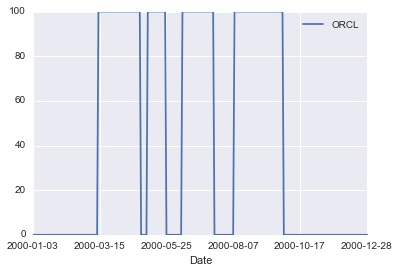

In [383]:
portfolio.positions.plot()

## Plot the results!

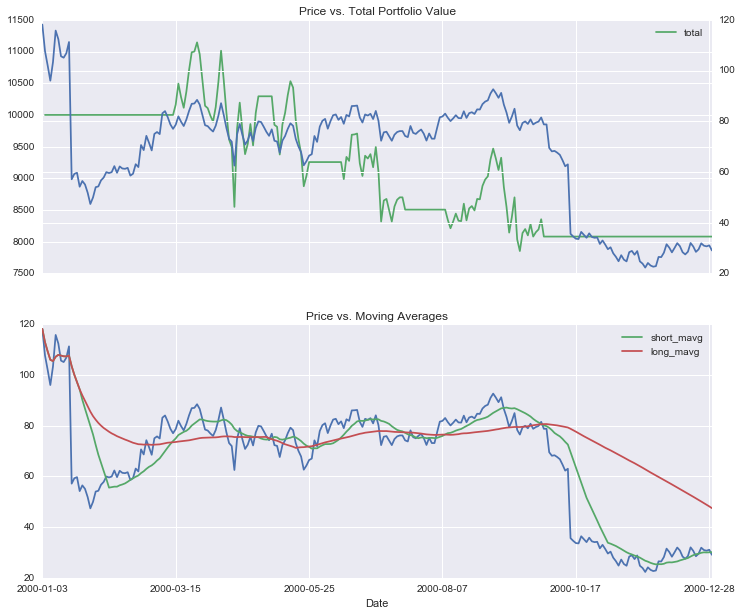

In [277]:
##plot the results!
fig, axs = plt.subplots(2,1)
#markers=list(portfolio.signals[portfolio.signals.positions!=0]['positions'].index)
#markevery=markers,marker='^'
#,color='firebrick'

portfolio.bars['Close'].plot(secondary_y=True,ax=axs[0])
portfolio.portfolio[['total']].plot(ax=axs[0])
axs[0].set_title('Price vs. Total Portfolio Value')
portfolio.bars['Close'].plot(ax=axs[1])
portfolio.signals[['short_mavg','long_mavg']].plot(figsize=(12,10),ax=axs[1])
axs[1].set_title('Price vs. Moving Averages')


### What next?
- Alter the code so that it can handle multiple securities.
- Add trade execution costs
- Design an alternative strategy based on another simple indicator - remember all you need to do is generate a 'signal'  series which moves up and down by one each time a strategy implies a buy or sell signals
- **(hard)** Consider the **size** of the trade that the alternative strategy should execute each time - should it be constant? If the new strategy can have a notion of the 'strength' of the signal, then let this reflect. Rather than being binary 0/1, the signal series can be continuous. 0 denotes no holdings, +ve denotes long position, -ve denotes short position.

## Multiple securities

In [288]:
data=quandl.get(['LSE/DOM.1','LSE/ARM.1'],start_date='2014-01-01')

In [413]:
class Portfolio():
    """A multiple-security portfolio, with bars-type data.
    ..attribs:
    :data: a dataframe with the closing prices for each security
    :signals: a dataframe of generated 'signals' for a given strategy. 
        The signals dataframe has  a series of integers for each security.
        The signal series changes by 1 +/- for each buy/sell trade.
    :initial_capital: Cash value at portfolio start.
    :tradesize: quantity (hundreds) of each security to buy/sell with each trade.
    """
    def __init__(self,data,signals,initial_capital,tradesize=5):
        self.data=data
        self.signals=signals
        self.tradesize=tradesize
        self.initial_capital=initial_capital

    def generate_positions(self):
        """
        This method takes the signals dataframe and creates a security position by multiplying by tradesize.
        """
        positions = pd.DataFrame(self.tradesize*self.signals,index=self.signals.index)
        self.positions=positions
        return positions

    def backtest_portfolio(self):
        """Backtest the portfolio given the given strategy.
        This method creates an aggregate backtest dataframe self.portfolio.
        self.portfolio has a number of columns:
        :holdings: Market value of the security holding.
        :cash: Total value of cash in the portfolio
        :total: Total value of cash + holdings
        :returns: d-o-d return
        :cumulative: cumulative return over time
        """
        aggregate=pd.DataFrame(self.positions * self.data,columns=self.data.columns)
        pos_diff = self.positions.diff()
        summary=pd.DataFrame(index=self.data.index)
        summary['cash']=self.initial_capital - (pos_diff*self.data).cumsum().sum(axis=1)
        summary['total']=summary['cash']+aggregate.sum(axis=1)
        summary['returns']=summary['total'].pct_change()
        summary['cumulative']=summary['returns'].cumsum()
        self.portfolio = aggregate
        self.summary=summary
        return summary

In [414]:
class MAStrategy():
    """A generic moving average crossover strategy.
    attribs:
        :data: the daily close data for securities
        :short_window, long_window: short and long MA filter periods.
    """
    def __init__(self,data,short_window,long_window):
        self.data = data
        self.short_window=short_window
        self.long_window=long_window

    def generate_signals(self):
        """This generates 'signals' for a trade whenever short moving average is greater than long moving average.
        The signal series for this strategy is simply 1 when short > long and 0 when long > short moving average.
        A very simple momentum-style strategy.
        """
        short_mavg=self.data.rolling(self.short_window, min_periods=1).mean()
        self.short_mavg=short_mavg
        long_mavg=self.data.rolling(self.long_window,min_periods=1).mean()
        self.long_mavg=long_mavg
        signals=pd.DataFrame(np.where(short_mavg>long_mavg,1,0),index=self.data.index,columns=self.data.columns)
        #not used, but useful to see where trades are executed.
        trades = signals.diff()
        self.signals=signals
        return signals

In [415]:
multiplemac=MAStrategy(data,30,80)

In [416]:
signals=multiplemac.generate_signals()

In [417]:
port=Portfolio(data,signals,10000)

In [418]:
positions=port.generate_positions()

In [419]:
summary=port.backtest_portfolio()

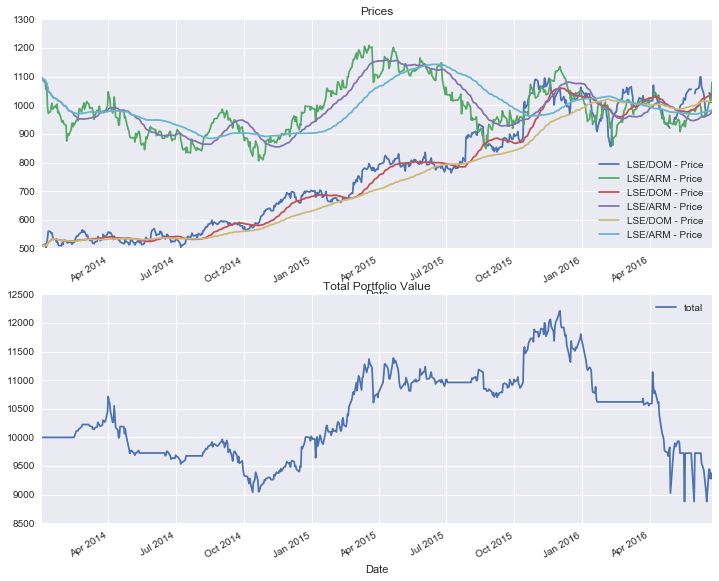

In [421]:
##plot the results!
fig, axs = plt.subplots(2,1)
#markers=list(portfolio.signals[portfolio.signals.positions!=0]['positions'].index)
#markevery=markers,marker='^'
#,color='firebrick'

port.data.plot(ax=axs[0])
multiplemac.short_mavg.plot(ax=axs[0])
multiplemac.long_mavg.plot(ax=axs[0])
port.summary[['total']].plot(ax=axs[1],figsize=(12,10))
axs[0].set_title('Prices')
axs[1].set_title('Total Portfolio Value')

#portfolio.bars['Close'].plot(ax=axs[1])
#portfolio.signals[['short_mavg','long_mavg']].plot(figsize=(12,10),ax=axs[1])
#axs[1].set_title('Price vs. Moving Averages')